***Github***

**->Packages**

In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import random_uniform, glorot_uniform

import os
import shutil
import json

from PIL import Image

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [43]:
# Creating a function to streamline the Train data set   
def train_img_path(id_str):
    return os.path.join(r"/kaggle/input/histopathologic-cancer-detection/train", f"{id_str}.tif")

**->Exploratory Data Analysis**

In this section, we'll begin by loading the data and, if necessary, carry out any further data cleaning. Afterward, we'll proceed with conducting a fundamental Exploratory Data Analysis (EDA).

It's important to mention that this dataset has undergone extensive tuning and cleaning by Kaggle previously. Therefore, there's generally no requirement for additional data cleaning; nevertheless, we can still undertake a basic EDA.

Image Shape = (96, 96, 3)


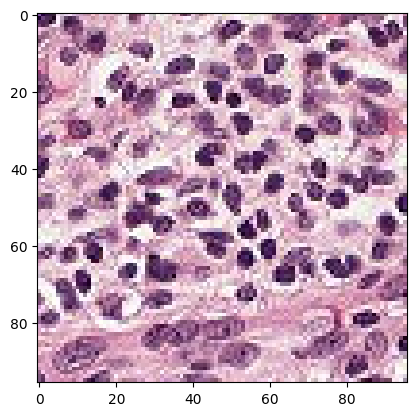

In [44]:
example_path = "/kaggle/input/histopathologic-cancer-detection/train/20003eed7b89727ab1bfee51d343f23b06c883ed.tif"
example_img = Image.open(example_path)
example_array = np.array(example_img)
print(f"Image Shape = {example_array.shape}")
plt.imshow(example_img)
plt.show()

We possess images with dimensions of (96, 96, 3), where the height is 96, the width is 96, and we have three channels representing the standard RGB channels. The images maintain this consistent shape across both the training and test sets.

Next, we'll establish a dataframe to store the id, label, and filename. This dataframe will play a crucial role in training the data generator for fitting the dataset.

In [45]:
train_labels_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_labels_df["filename"] = train_labels_df["id"].apply(train_img_path)
train_labels_df["label"] = train_labels_df["label"].astype(str)
train_labels_df.head()

,id,label,filename
0,f38a6374c348f90b587e046aac6079959adf3835,0,/kaggle/input/histopathologic-cancer-detection...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/kaggle/input/histopathologic-cancer-detection...
2,755db6279dae599ebb4d39a9123cce439965282d,0,/kaggle/input/histopathologic-cancer-detection...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/kaggle/input/histopathologic-cancer-detection...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/kaggle/input/histopathologic-cancer-detection...


In [46]:
train_labels_df.shape


(220025, 3)

In [47]:
set(train_labels_df['label'])


{'0', '1'}

In the training dataset, there are a total of 220,025 images, and these images are associated with two distinct labels. The label '0' signifies non-cancerous tissues, while '1' represents cancerous tissues.

In [48]:
train_labels_df['label'].value_counts(normalize = True)


label
0    0.594969
1    0.405031
Name: proportion, dtype: float64

Approximately 40.5% of the training dataset consists of cancerous tissues, while the remaining 59.5% comprises tissues without cancerous tumors. The dataset exhibits a slight imbalance, but it doesn't reach a level that would necessitate fine-tuning or major adjustments.

In [49]:
sample_data = np.empty((100, 96, 96, 3), dtype=np.uint8)
sample_labels = np.empty(100, dtype=np.int8)
for i in range(len(train_labels_df))[:100]:
    img_path = train_img_path(train_labels_df['id'][i])
    img = Image.open(img_path)
    sample_data[i] = np.array(img)
    sample_labels[i] = train_labels_df['label'][i]

Non-Cancerous Images


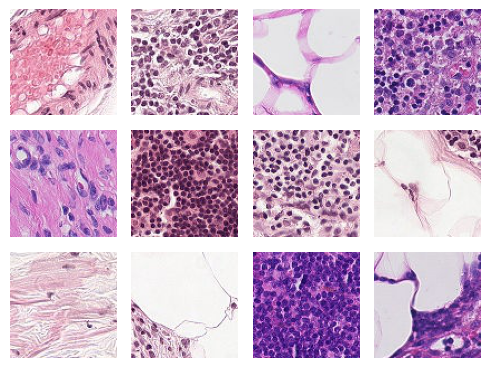

In [50]:
print("Non-Cancerous Images")

selected_images = np.random.choice(sample_data[sample_labels == 0].shape[0], 12, replace=False)
grid_size = int(np.ceil(np.sqrt(12)))

fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))

for i, ax in enumerate(axs.flatten()):
    if i < 12:
        ax.imshow(sample_data[sample_labels == 0][selected_images[i]])
        ax.axis('off') 
    else:
        fig.delaxes(ax) 

plt.tight_layout()
plt.show()

Cancerous Images


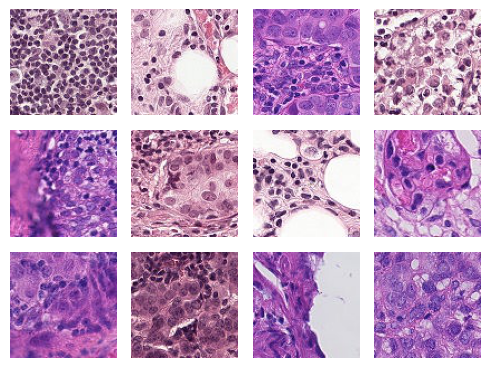

In [51]:
print("Cancerous Images")

selected_images = np.random.choice(sample_data[sample_labels == 1].shape[0], 12, replace=False)
grid_size = int(np.ceil(np.sqrt(12)))

fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))

for i, ax in enumerate(axs.flatten()):
    if i < 12:
        ax.imshow(sample_data[sample_labels == 1][selected_images[i]])
        ax.axis('off') 
    else:
        fig.delaxes(ax) 

plt.tight_layout()
plt.show()

Looking at the random images of both cancerous and non-cancerous tissues shown above, it becomes apparent that the tumor is not discernible to an untrained human eye. For the general population, these images do not exhibit significant differences.

**->Model Designing**

In this section, we will undertake a series of necessary steps to construct the Resnet 50 model effectively. We will begin by loading the data from the disk and configuring the training and validation data generators. Additionally, we'll set up a test generator for the final submission phase.

Following that, we will proceed to craft a customized Resnet 50 model tailored to the specific requirements of this task.

In [52]:
test_path = "/kaggle/input/histopathologic-cancer-detection/test"
test_ids = [filename[:-4] for filename in os.listdir(test_path)]
test_filenames = [os.path.join(test_path, filename) for filename in os.listdir(test_path)]
test_df = pd.DataFrame()
test_df["id"] = test_ids
test_df["filename"] = test_filenames

In [53]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255, validation_split = 0.2)

In [54]:
train_generator = datagen.flow_from_dataframe(
    shuffle = True,
    dataframe = train_labels_df,
    x_col = "filename",
    y_col = "label",
    target_size = (96, 96),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = "binary",
    subset = "training",
    validate_filenames = False,
    seed = 10
)

validation_generator = datagen.flow_from_dataframe(
    shuffle = True,
    dataframe=train_labels_df,
    x_col = "filename",
    y_col = "label",
    target_size=(96, 96),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = "binary",
    subset = "validation",
    validate_filenames = False,
    seed = 10
)

Found 176020 non-validated image filenames belonging to 2 classes.
Found 44005 non-validated image filenames belonging to 2 classes.


In [55]:
test_generator = datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = "filename",
    y_col = None,
    target_size = (96, 96),
    color_mode = "rgb",
    batch_size = 64,
    shuffle = False,
    class_mode = None,
    validate_filenames = False,
    seed = 10
)

Found 57458 non-validated image filenames.


In [56]:
train_steps = 176020//32  # 8000 images for training
val_steps = 44005//32

Now, we will construct the Resnet50 model.

It's worth mentioning that we have the option to employ transfer learning by importing the model and its pre-trained parameters from the TensorFlow API, based on ImageNet. However, for this project, we will design a customized model.

Our model will consist of two types of blocks: identity blocks, where the input and output dimensions remain the same, and convolutional blocks, where the input and output dimensions are allowed to change. In both types of blocks, we will incorporate robust skip connections.

Following the convolutional layers, we will add fully connected layers, with the final output being a dense Sigmoid unit.

By the end of this process, we will have constructed a Resnet model with a total of 50 layers.

In [57]:
def identity_block(X, f, filters, training=True, initializer = random_uniform):
    """
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = tfl.Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = tfl.Activation('relu')(X)
    
    ## Set the padding = 'same'
    X = tfl.Conv2D(filters = F2, kernel_size = f, strides = 1, padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training = training)
    X = tfl.Activation('relu')(X)


    ## Set the padding = 'valid'
    X = tfl.Conv2D(filters = F3, kernel_size = 1, strides = 1, padding = 'valid', kernel_initializer = initializer(seed = 0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training = training) 
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = tfl.Add()([X, X_shortcut])
    X = tfl.Activation('relu')(X)

    return X
def convolutional_block(X, f, filters, s = 2, training=True, initializer = glorot_uniform):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    X = tfl.Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training=training)
    X = tfl.Activation('relu')(X)
    
    X = tfl.Conv2D(filters = F2, kernel_size = (f,f), strides = 1, padding='same', kernel_initializer = initializer(seed=0))(X) 
    X = tfl.BatchNormalization(axis = 3)(X, training=training)
    X = tfl.Activation('relu')(X) 

    X = tfl.Conv2D(filters = F3, kernel_size = 1, strides = 1, padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training=training) 

    X_shortcut = tfl.Conv2D(filters = F3, kernel_size = (1,1), strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = tfl.BatchNormalization(axis = 3)(X_shortcut, training=training)
    
    X = tfl.Add()([X, X_shortcut])
    X = tfl.Activation('relu')(X)
    
    return X

In [58]:
def ResNet50(input_shape = (96, 96, 3)):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = tfl.Input(input_shape)

    
    # Zero-Padding
    X = tfl.ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = tfl.Conv2D(96, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X)
    X = tfl.Activation('relu')(X)
    X = tfl.MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ### START CODE HERE
    
    # Use the instructions above in order to implement all of the Stages below
    # Make sure you don't miss adding any required parameter
    
    ## Stage 3 (≈4 lines)
    # `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    
    # the 3 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    
    # the 5 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3,[256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    
    # the 2 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D()(X)"
    X = tfl.AveragePooling2D(pool_size = (2,2))(X)
    

    # output layer
    X = tfl.Flatten()(X)
    X = tfl.Dense(1, kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [59]:
model = ResNet50(input_shape = (96, 96, 3))
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 102, 102, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_57 (Conv2D)             (None, 48, 48, 96)   14208       ['zero_padding2d_2[0][0]']       
                                                                                                  
 batch_normalization_57 (BatchN  (None, 48, 48, 96)  384         ['conv2d_57[0][0]']        

The model summary is provided above, revealing a total of 23,551,681 trainable parameters. If we opt for a deeper network architecture, the number of parameters will likely increase, potentially leading to improved accuracy or AUC (Area Under the Curve). However, for this specific model, we will stick with the Resnet 50 architecture.

**->Model Deployment**

In this section, we will take the previously constructed model and train it using the Adam optimizer with binary cross-entropy as the loss function. To enhance accuracy, we have utilized `from_logits=True`. However, if the reader prefers to avoid this setting, they can modify the final output layer in the Resnet50 model described earlier and replace the activation function with sigmoid instead of linear.

In [60]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss=tf.keras.losses.BinaryCrossentropy(from_logits = True), metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    validation_data = validation_generator,
    validation_steps = val_steps,
    epochs = 10
)

Epoch 1/10
5500/5500 [==============================] - 1493s 271ms/step - loss: 0.2986 - accuracy: 0.8710 - val_loss: 0.2734 - val_accuracy: 0.8760
Epoch 2/10
5500/5500 [==============================] - 612s 111ms/step - loss: 0.2357 - accuracy: 0.9026 - val_loss: 0.2340 - val_accuracy: 0.9121
Epoch 3/10
5500/5500 [==============================] - 514s 93ms/step - loss: 0.1954 - accuracy: 0.9216 - val_loss: 0.2060 - val_accuracy: 0.9209
Epoch 4/10
5500/5500 [==============================] - 505s 92ms/step - loss: 0.1708 - accuracy: 0.9326 - val_loss: 0.2656 - val_accuracy: 0.8784
Epoch 5/10
5500/5500 [==============================] - 498s 91ms/step - loss: 0.1520 - accuracy: 0.9411 - val_loss: 0.1964 - val_accuracy: 0.9253
Epoch 6/10
5500/5500 [==============================] - 490s 89ms/step - loss: 0.1387 - accuracy: 0.9464 - val_loss: 0.1537 - val_accuracy: 0.9443
Epoch 7/10
5500/5500 [==============================] - 492s 89ms/step - loss: 0.1274 - accuracy: 0.9514 - val_loss: 0.1625 - val_accuracy: 0.9354
Epoch 8/10
5500/5500 [==============================] - 498s 91ms/step - loss: 0.1161 - accuracy: 0.9559 - val_loss: 0.1592 - val_accuracy: 0.9440
Epoch 9/10
5500/5500 [==============================] - 499s 91ms/step - loss: 0.1064 - accuracy: 0.9603 - val_loss: 0.1394 - val_accuracy: 0.9453
Epoch 10/10
5500/5500 [==============================] - 505s 92ms/step - loss: 0.0989 - accuracy: 0.9627 - val_loss: 0.1408 - val_accuracy: 0.9476

It takes around 2 hours to train the model with 10 epochs and Kaggle P100 GPU. We can increase the number of epochs but only Training loss decrease for some time after 10 epochs with little change in validation loss and accuracy. In fact we can see from above that after 6th Epoch Validation Accruacy has not changed much.

So, it will not be efficient to train with more epochs but readers can do it if they have resources and time for this.

**->Model Evaluation**

Model evaluation is constrained in this context due to the absence of labels for the test dataset. Nonetheless, we will carry out a rudimentary evaluation to understand the limitations that prevent us from conducting a more comprehensive model assessment.

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


val_predictions = tf.nn.sigmoid(model.predict(validation_generator)).numpy()
val_pred_classes = (val_predictions > 0.5).astype(int).flatten() #Threshold is assumed to be 0.5 for this cell

# True labels
true_labels = validation_generator.classes

# Ensure the lengths match
val_pred_classes = val_pred_classes[:len(true_labels)]

# Calculate metrics
accuracy = accuracy_score(true_labels, val_pred_classes)
precision = precision_score(true_labels, val_pred_classes)
recall = recall_score(true_labels, val_pred_classes)
f1 = f1_score(true_labels, val_pred_classes)
roc_auc = roc_auc_score(true_labels, val_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

1376/1376 [==============================] - 625s 454ms/step
Accuracy: 0.5311
Precision: 0.4004
Recall: 0.3236
F1 Score: 0.3579
ROC-AUC: 0.4990


The threshold of 0.5 employed above is merely an assumption and is not accurate. Since the dataset doesn't provide a predefined decision boundary, using the metrics mentioned above to evaluate the model's performance is not appropriate.

To assess the model's performance accurately, we must generate a submission and measure the AUC obtained from such a submission.

In [ ]:
best_loss = history['val_loss'][i_min]
best_accuracy = history['val_accuracy'][i_min]
best_auc = history['val_auc'][i_min]

**->Submission**

In [ ]:
test_probs = model.predict(test_generator)


898/898 [==============================] - 116s 129ms/step


In [ ]:
test_labels = np.round(test_probs).astype(int).flatten()
out_df = pd.DataFrame()
out_df["id"] = test_ids
out_df["label"] = test_labels
out_df.to_csv(os.path.join('/kaggle/working/', "test_labels.csv"), index=False)

In [ ]:
import shutil
submission_file = r"/kaggle/working/test_labels.csv"
shutil.copy(submission_file, "submission.csv")

****Conclusion****

In the final submission, we achieved a public Area Under the ROC Curve (AUC) score of 0.9463 and a private score of 0.9167. This outcome is considered acceptable, especially considering that we utilized only a single deep Resnet Model with 50 layers.

To potentially enhance the score further, we have several options available. We can explore building even deeper neural networks, consider leveraging transfer learning by importing architectures like Mobilenet or Inception-Resnet, or opt for architectures with more than 150 hidden layers. Additionally, we can improve model accuracy by implementing data augmentation techniques and increasing the size of the training dataset.

In summary, with the Resnet50 model, we achieved a Test AUC of 0.9463 on the Histopathological cancer detection dataset. The training loss was 0.0989, accompanied by an accuracy of 0.9627, while the validation loss stood at 0.1408, with a validation accuracy of 0.9476. We can further aim to enhance the model's performance by exploring deeper architectures and other optimization strategies.